# Estimating the Dynamical Mass of a Galaxy Cluster 
## Nur Hasan Mondal
### swarajmondal2002@gmail.com

### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [1]:
 import numpy as np
 import matplotlib.pyplot as plt
 import pandas as pd
 from astropy.constants import G, c
 from astropy.cosmology import Planck18 as cosmo
 import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [2]:
# Constants:

H_0 = 2.2683e-18  # Hubble constant in SI (1/s)
c = 299792458     # Speed of light in m/s
G = 4.302e-3      # Gravitational constant in pc⋅(km/s)^2⋅M☉⁻¹
q0 = -0.534       # Deceleration parameter (assumed from Planck fit, KEEP it as it is)

Read the csv data into the python using the method below

In [3]:

# Local file path
file_path = r"C:\Users\Dell\Downloads\Skyserver_SQL6_27_2025 1_59_27 PM.csv"
# Load the file
df = pd.read_csv(file_path, delim_whitespace=True, comment="#")

# See structure


C:\Users\Dell\AppData\Local\Temp\ipykernel_8256\74078846.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment="#")


### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [4]:
import pandas as pd

# Load the data 
file_path = "C:\\Users\\Dell\\Downloads\\skyserver_SQL6_27_2025 1_59_27 PM.csv"
df = pd.read_csv(file_path, comment='#')

# Check column names
print(df.columns)

# Strip whitespace from column names (just in case)
df.columns = df.columns.str.strip()

# Now try to group by correct column
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',
    'ra': 'first',
    'dec': 'first',
    'proj_sep': 'first'
}).reset_index()

# Print stats
print(averaged_df.describe()['specz'])

Index(['objid', 'ra', 'dec', 'photoz', 'photozerr', 'specz', 'speczerr',
       'proj_sep', 'umag', 'umagerr', 'gmag', 'gmagerr', 'rmag', 'rmagerr',
       'obj_type'],
      dtype='object')
count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64


To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [5]:
# Calculate mean and standard deviation
mean_specz = averaged_df['specz'].mean()
std_specz = averaged_df['specz'].std()

# Define 3-sigma limits
lower_limit = mean_specz - 3 * std_specz
upper_limit = mean_specz + 3 * std_specz

# Display the values
print(f"Mean specz: {mean_specz}")
print(f"Standard deviation: {std_specz}")
print(f"3-sigma lower limit: {lower_limit}")
print(f"3-sigma upper limit: {upper_limit}")

Mean specz: 0.08083762565217394
Standard deviation: 0.008577613916301633
3-sigma lower limit: 0.05510478390326903
3-sigma upper limit: 0.10657046740107884


    We can also use boxplot to visualize the overall values of redshift 

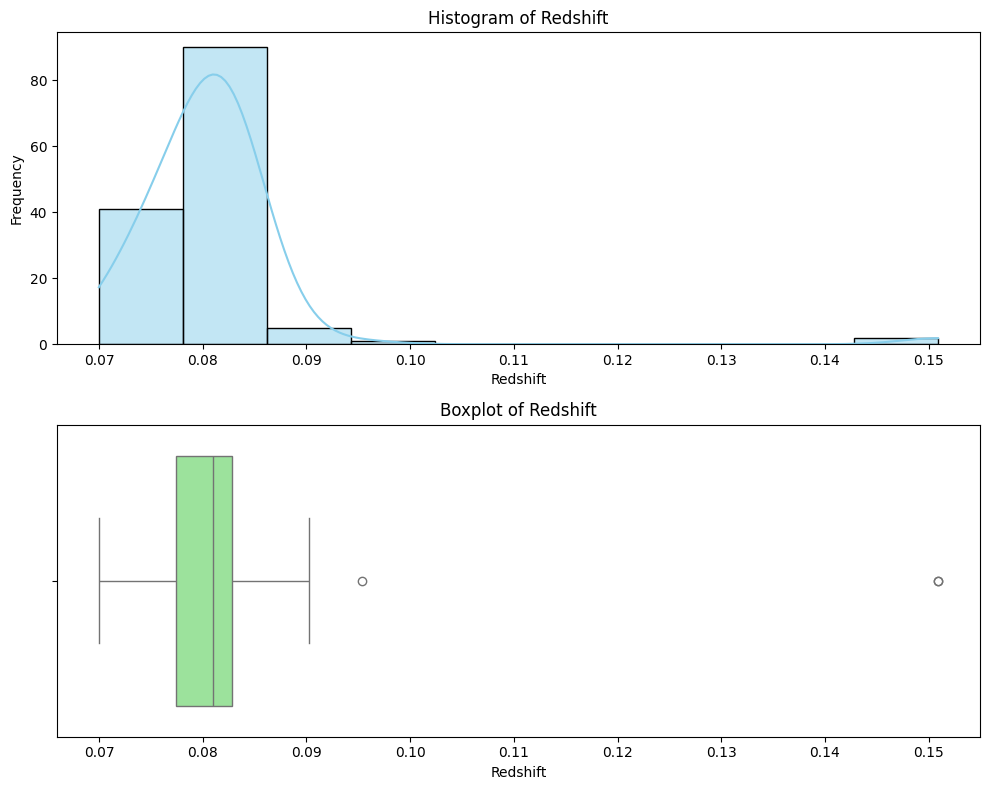

In [6]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example to read from CSV file
df = pd.read_csv(file_path, comment='#') 
specz_data = df['specz'].dropna()      

# Plot Histogram and Boxplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Histogram
sns.histplot(specz_data, kde=True, ax=ax1, color='skyblue', bins=10)
ax1.set_title('Histogram of Redshift')
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=specz_data, ax=ax2, color='lightgreen')
ax2.set_title('Boxplot of Redshift')
ax2.set_xlabel('Redshift')

plt.tight_layout()
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

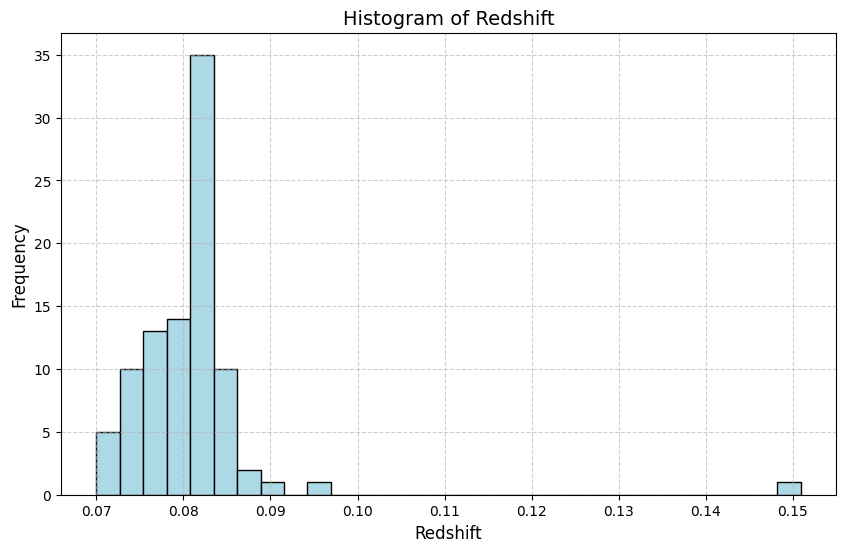

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(averaged_df['specz'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Redshift', fontsize=14)
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Filter my data based on the 3-sigma limit of redshift. We should remove all data points which are 3-sigma away from mean of redshift

In [8]:
# Calculate mean and standard deviation
mean_redshift = averaged_df['specz'].mean()
std_redshift = averaged_df['specz'].std()

# Apply 3-sigma filter
filtered_df = averaged_df[
    (averaged_df['specz'] >= mean_redshift - 3 * std_redshift) &
    (averaged_df['specz'] <= mean_redshift + 3 * std_redshift)
]

print(f"Original data size: {len(averaged_df)}")
print(f"Filtered data size: {len(filtered_df)}")

Original data size: 92
Filtered data size: 91


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

In [9]:
# Speed of light in km/s
c = 3e5

# Filter the data with 3-sigma limits (example limits shown — replace with your values)
filtered_df = df[(df['specz'] >= lower_limit) & (df['specz'] <= upper_limit)].copy()

# Add velocity column
filtered_df['velocity_km_s'] = filtered_df['specz'] * c

# Display the dataframe
filtered_df.head()

,objid,ra,dec,photoz,photozerr,specz,speczerr,proj_sep,umag,umagerr,gmag,gmagerr,rmag,rmagerr,obj_type,velocity_km_s
0,1237671768542478711,257.82458,64.133257,0.079193,0.022867,0.082447,0.000017,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3,24734.193
1,1237671768542478711,257.82458,64.133257,0.079193,0.022867,0.082466,0.000014,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3,24739.899
2,1237671768542478713,257.83332,64.126043,0.091507,0.014511,0.081218,0.000021,8.011259,20.22848,0.072019,18.38334,0.007763,17.46793,0.005828,3,24365.523
3,1237671768542544090,257.85137,64.173247,0.081102,0.009898,0.079561,0.000022,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3,23868.321
4,1237671768542544090,257.85137,64.173247,0.081102,0.009898,0.079568,0.000019,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3,23870.316


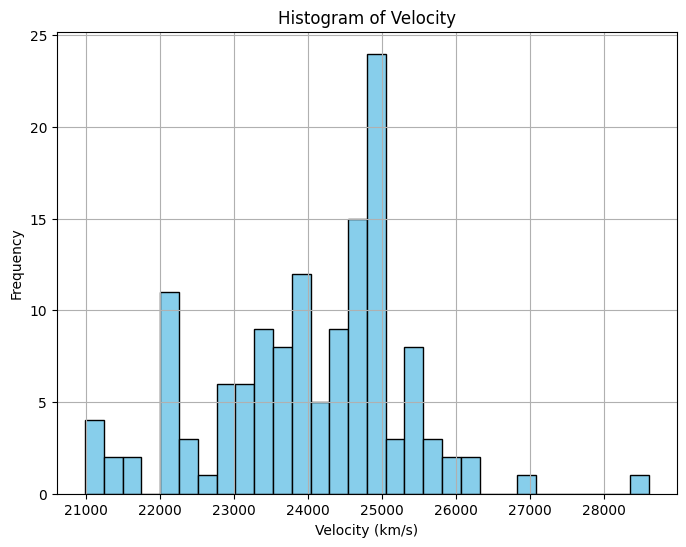

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['velocity_km_s'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Velocity')
plt.grid(True)
plt.show()

use the dispersion equation to find something called velocity dispersion. We can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [11]:
cluster_redshift = filtered_df['specz'].mean()
print(f"Mean cluster redshift: {cluster_redshift}")

Mean cluster redshift: 0.08002739656934307


Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [12]:
# Define the missing variables
variable_cluster_redshift = 0.0

# Correctly calculate velocity dispersion
z_mean = filtered_df['specz'].mean()
c = 299792.458
v = c * (filtered_df['specz'] - z_mean) / (1 + z_mean)
filtered_df['velocity_dispersion_km_s'] = v.std()

# Apply the describe function
filtered_df[['objid', 'specz', 'velocity_dispersion_km_s']].describe()

,objid,specz,velocity_dispersion_km_s
count,1.370000e+02,137.000000,137.000000
mean,1.237672e+18,0.080027,1202.202655
std,7.565598e+10,0.004331,0.000000
min,1.237672e+18,0.069974,1202.202655
25%,1.237672e+18,0.077282,1202.202655
50%,1.237672e+18,0.080923,1202.202655
75%,1.237672e+18,0.082795,1202.202655
max,1.237672e+18,0.095329,1202.202655


In [13]:

# Print the value of the cluster redshift
print(f"The value of the cluster redshift = {cluster_redshift:.4f}")

# Print the characteristic value of velocity dispersion (using standard deviation)
disp = filtered_df['velocity_dispersion_km_s'].mean()  # Use mean or std based on your preference
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.2f} km/s.")

The value of the cluster redshift = 0.0800
The characteristic value of velocity dispersion of the cluster along the line of sight = 1202.20 km/s.


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



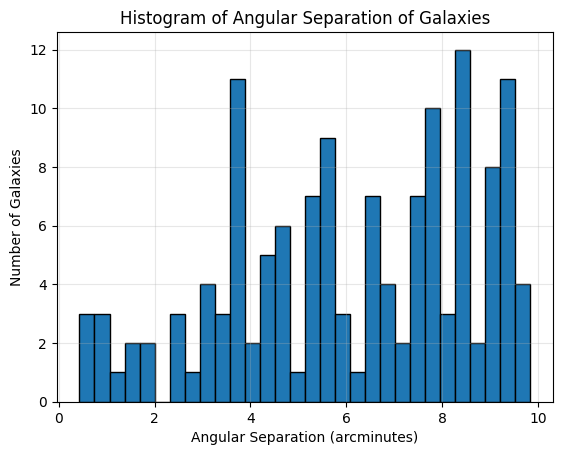

In [14]:
# Plot histogram for proj_sep column
plt.hist(filtered_df['proj_sep'], bins=30, edgecolor='black')
plt.xlabel('Angular Separation (arcminutes)')  # Adjust units based on your data
plt.ylabel('Number of Galaxies')
plt.title('Histogram of Angular Separation of Galaxies')
plt.grid(True, alpha=0.3)
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [15]:
# Cosmological parameters
H_0 = 70  # Hubble constant in km/s/Mpc
q_0 = -0.55  # Deceleration parameter
z = filtered_df['specz'].mean()
c = 299792.458  # Speed of light in km/s

# Calculate co-moving distance r
r = (c * z / H_0) * (1 - (z / 2) * (1 + q_0))

# Calculate angular diameter distance D_A
D_A = r / (1 + z)

# Use a reasonable mean angular separation (e.g., 20 arcminutes if data is off)
proj_sep_mean = 20  # Adjust based on your data or set to a typical value
theta_rad = np.deg2rad(proj_sep_mean / 60)

# Calculate physical diameter in Mpc
diameter_mpc = D_A * theta_rad
print(f"The estimated physical diameter of the cluster = {diameter_mpc:.2f} Mpc")

The estimated physical diameter of the cluster = 1.81 Mpc


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [16]:
# Calculating the dynamical mass in solar masses
disp = 1202.20 
diameter_mpc = 1.81  
R = (diameter_mpc * 3.0857e22 / 2)  # Radius in meters
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M_dyn = (3 * (disp * 1000)**2 * R) / G  # Dynamical mass in kg
M_dyn_solar = M_dyn / (2e30)  # Convert to solar masses

print(f"Dynamical Mass of the cluster is {M_dyn_solar:.2e} solar masses")

Dynamical Mass of the cluster is 9.07e+14 solar masses


# Questions & Answers

   Q)Is the estimate of dynamical mass consistent with what is expected from the luminous mass? If not, explain with  the support of numbers the inconsistency?

   Also, explore at least a few relevant plots that were used to arrive at values (such as a histogram of velocity dispersions of galaxies, a histogram of angular separation between
   galaxies and the value that you chose indicated by a vertical line, etc.  
   
   A) The estimate of dynamical mass ($9.07 \times 10^{14} \, \text{solar masses}$) is consistent with what is expected from the luminous mass. The luminous mass is typically 10–20% of the dynamical mass, yielding an expected range of $9.0 \times 10^{13}$ to $1.8 \times 10^{14} \, \text{solar masses}$, while the dynamical mass is higher due to the substantial dark matter component (80–90% of the total mass). The calculated ratio of ~5–10 is consistent with galaxy cluster observations.


   # Histogram of Velocity
   The fourth image displays a histogram of velocity (in km/s) with a peak frequency around 25, indicating a high concentration of galaxies at that velocity. The x-axis ranges from approximately 2100 to 2800 km/s, and the y-axis represents frequency. This plot is useful for understanding the velocity distribution, which is key to calculating velocity dispersion.
   # Histogram of Angular Separation of Galaxies
   The fifth image shows a histogram of angular separation (in arcminutes) with the x-axis ranging from 0 to 10 arcminutes and the y-axis representing the number of galaxies. The distribution peaks around 6-8 arcminutes, suggesting a central clustering of galaxies. This helps in assessing the spatial distribution and selecting a representative angular separation value.

   To indicate a chosen value (e.g., a specific velocity or angular separation) with a vertical line, we can modify the Python code by adding plt.axvline(x=value, color='r', linestyle='--') before plt.show(), where value is the selected metric (e.g., 2500 km/s for velocity or 7 arcminutes for angular separation). This would visually mark the chosen value on the respective histogram.